In [60]:
import pandas as pd
import numpy as np
from SERGIO.SERGIO.sergio import sergio
from GENIE3.GENIE3 import *
import MAGIC.magic as magic
import SAUCIE.SAUCIE as SAUCIE
import scScope.scscope.scscope as DeepImpute
import deepimpute.deepimpute as deepimpute

import os
import h5py
import importlib
import scprep
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix, csc_matrix

In [61]:
#file_path = './network_data/HU_0107_Bladder_GSE134355_gene_count.h5'
file_path = './network_data/HU_0379_Blood_GSE172495_gene_count.h5'
#file_path = './network_data/HU_0142_Breast_GSE138536_gene_count.h5'

with h5py.File(file_path, 'r') as h5file:
    if 'matrix' in h5file:
        shape = tuple(h5file['matrix']['shape'][:])
        print("Shape of matrix: ", shape)

        data = h5file['matrix']['data'][:]
        indices = h5file['matrix']['indices'][:]
        indptr = h5file['matrix']['indptr'][:]

        matrix = csc_matrix((data, indices, indptr), shape=shape)
        dense_matrix = matrix.toarray()
        df = pd.DataFrame(data=dense_matrix)
        df.replace(0, 1e-5, inplace=True)

Shape of matrix:  (11738, 1253)


In [62]:
df

,0,1,2,3,4,5,6,7,8,9,...,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252
0,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
1,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,2.412415,0.00001,0.00001,0.00001,0.000010,0.00001
2,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
3,1.525828,1.476872,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
4,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11733,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
11734,0.000010,0.000010,0.00001,0.00001,0.00001,2.056643,0.00001,0.00001,1.89862,0.00001,...,0.00001,0.00001,0.00001,2.537908,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
11735,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,1.89862,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001
11736,0.000010,0.000010,0.00001,0.00001,0.00001,0.000010,0.00001,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000010,0.000010,0.00001,0.00001,0.00001,2.809927,0.00001


In [78]:
def run_saucie(x_path, y_path, ind, save_path):
    #reload_modules('tensorflow.compat')
    tf = importlib.import_module('tensorflow.compat.v1')
    #importlib.reload(SAUCIE)
    tf.disable_v2_behavior()
    print("loading data")
    y = np.transpose(np.load(y_path))
    x = np.transpose(np.load(x_path))
    print("reset graph")
    tf.reset_default_graph()
    print("Initialize saucie")
    saucie = SAUCIE.SAUCIE(y.shape[1])
    print("Load saucie")
    loadtrain = SAUCIE.Loader(y, shuffle=True)
    print("Train saucie")
    saucie.train(loadtrain, steps=1000)

    loadeval = SAUCIE.Loader(y, shuffle=False)
    # embedding = saucie.get_embedding(loadeval)
    # number_of_clusters, clusters = saucie.get_clusters(loadeval)
    rec_y = saucie.get_reconstruction(loadeval)
    save_str = '/yhat_SAUCIE'
    np.save(save_path + save_str, rec_y)

def run_deepImpute(x_path, y_path, ind, save_path):
    #reload_modules('tensorflow.compat')
    importlib.invalidate_caches()
    multinet = importlib.import_module('deepimpute.deepimpute.multinet')
    importlib.reload(multinet)
    tf = importlib.import_module('tensorflow.compat.v1')
    #tf = importlib.import_module('tensorflow')
    tf.init_scope()
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    y = np.transpose(np.load(y_path))
    y = 10 ** y
    y = pd.DataFrame(y)
    x = np.transpose(np.load(x_path))
    x = pd.DataFrame(x)
    multinet = multinet.MultiNet()
    multinet.fit(y,cell_subset=1,minVMR=0.5)
    imputedData = multinet.predict(y)
    yhat_deepimpute = imputedData.to_numpy()
    save_str = '/yhat_deepImpute'
    np.save(save_path + save_str, yhat_deepimpute)

def run_magic(x_path, y_path, ind, save_path):
    print(x_path, y_path)
    y = np.transpose(np.load(y_path))
    x = np.transpose(np.load(x_path))
    
    y_hat = scprep.filter.filter_rare_genes(y, min_cells=5)
    y_norm = scprep.normalize.library_size_normalize(y_hat)
    y_norm = scprep.transform.sqrt(y_norm)

    for t_val in [7]:
        magic_op = magic.MAGIC(
            t=t_val,
            n_pca=20,
            n_jobs=-1,
        )
        y_hat = magic_op.fit_transform(y_norm, genes='all_genes')
        save_str = '/yhat_MAGIC_t_' + str(t_val)
        np.save(save_path + save_str, y_hat)

def run_scScope(x_path, y_path, ind, save_path):
    y = np.transpose(np.load(y_path))
    x = np.transpose(np.load(x_path))
    DI_model = DeepImpute.train(
          y,
          15,
          use_mask=True,
          batch_size=64,
          max_epoch=1000,
          epoch_per_check=100,
          T=2,
          exp_batch_idx_input=[],
          encoder_layers=[],
          decoder_layers=[],
          learning_rate=0.0001,
          beta1=0.05,
          num_gpus=1)
    latent_code, rec_y, _ = DeepImpute.predict(y, DI_model, batch_effect=[])
    save_str = '/yhat_scScope'
    np.save(save_path + save_str, rec_y)

def gt_benchmark(virtual_imputation, target_file):
    # Create numpy array of same size as imputation_dataset
    gt_temp = np.zeros_like(virtual_imputation)
    f = open(target_file,'r')
    Lines = f.readlines()
    f.close()
    # For each real gene and measured gene expressions, set new array at coordinates to 1
    for j in tqdm(range(len(Lines))):
        line = Lines[j]
        line_list = line.split(',')
        target_index = int(float(line_list[0]))
        num_regs = int(float(line_list[1]))
        # skip if gene is not present in filtered dataset
        if target_index >= gt_temp.shape[1]:
            for i in range(0, target_index + 1 - gt_temp.shape[1]):
                new_column = np.zeros((gt_temp.shape[0], 1), dtype=int)
                gt_temp = np.append(gt_temp, new_column, axis=1)
                virtual_imputation = np.append(virtual_imputation, new_column, axis=1)
        for i in range(num_regs):
            reg_index = int(float(line_list[i+2]))
            gt_temp[reg_index,target_index] = 1  
    return gt_temp, virtual_imputation

In [84]:
def create_graph(data, cutoff=0.95, method_name='None'):
    edges = pd.DataFrame(data)
    threshold = np.quantile(edges.values.flatten(), cutoff)
    
    G = nx.DiGraph()
    mask = edges >= threshold
    rows, cols = np.where(mask)
    for row, col in zip(rows, cols):
        weight = edges.iat[row, col]
        gene_1 = edges.index[row]
        gene_2 = edges.columns[col]
        G.add_edge(gene_1, gene_2, weight=weight)    
    pos = nx.spring_layout(G)
    es, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=es, edge_color=weights, width=1, edge_cmap=plt.cm.Blues)

    if method_name == 'None':
        plt.title('Top GRN Inference Edges')
    else:
        plt.title('Top GRN Inference Edges with Imputation Method ' + method_name)
    plt.axis('off')
    plt.show()
    return G

In [85]:
def run_GRN_and_graph(data, n_genes=100):
    print("Num genes:", n_genes)
    #sampled = data.sample(n=n_genes, random_state=42)
    #np.save('./zero_imputation_experiments/sampled.npy', sampled)
    sampled = pd.DataFrame(np.load('./zero_imputation_experiments/sampled.npy'))
    edges_dict = {}
    for i, method in enumerate([None, 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']):
        print(i, method)
        if method is None:
            x = np.transpose(sampled.values)
            method = 'None'
        elif method == 'SAUCIE':
            print("Running SAUCIE")
            run_saucie('./zero_imputation_experiments/sampled.npy', './zero_imputation_experiments/sampled.npy', i, './zero_imputation_experiments/')
            x = np.load('./zero_imputation_experiments/yhat_SAUCIE.npy')
        elif method == 'scScope':
            print("Running scScope")
            run_scScope('./zero_imputation_experiments/sampled.npy', './zero_imputation_experiments/sampled.npy', i, './zero_imputation_experiments/')
            x = np.load('./zero_imputation_experiments/yhat_scScope.npy')
        elif method == 'DeepImpute':
            print("Running DeepImpute")
            run_deepImpute('./zero_imputation_experiments/sampled.npy', './zero_imputation_experiments/sampled.npy', i, './zero_imputation_experiments/')
            x = np.load('./zero_imputation_experiments/yhat_deepImpute.npy')
        elif method == 'MAGIC':
            print("Running MAGIC")
            run_magic('./zero_imputation_experiments/sampled.npy', './zero_imputation_experiments/sampled.npy', i, './zero_imputation_experiments/')
            x = np.load('./zero_imputation_experiments/yhat_MAGIC_t_7.npy')
        x[x == 0] = 1e-5
        vim = GENIE3(x, nthreads=12, ntrees=100, regulators='all')
        G = create_graph(vim, cutoff=0.95, method_name=method)
        edges_dict[method] = set(G.edges())
    return edges_dict

Num genes: 100
0 None
Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 4.00 seconds


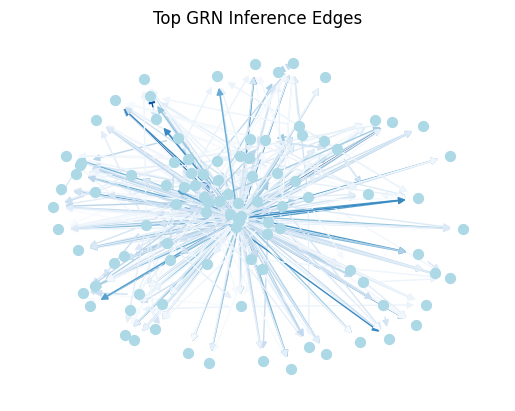

1 SAUCIE
Running SAUCIE
loading data
reset graph
Initialize saucie
Load saucie
Train saucie


/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/SAUCIE/SAUCIE/model.py:152: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h1 = tf.layers.dense(self.x, self.layers[0], activation=lrelu, name='encoder_0')
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/SAUCIE/SAUCIE/model.py:154: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h2 = tf.layers.dense(h1, self.layers[1], activation=tf.nn.sigmoid, name='encoder_1')
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/SAUCIE/SAUCIE/model.py:156: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h3 = tf.layers.dense(h2, self.layers[2], activation=lrelu, name='encoder_2')
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/SAUCIE/SAUCIE/model.py:158: UserW

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 11.77 seconds


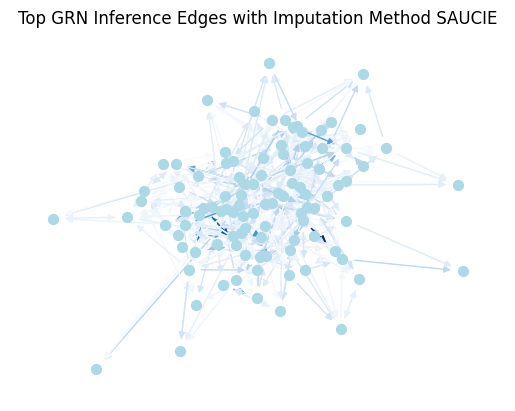

2 scScope
Running scScope
Building Computational Graph on GPU-0
Finisheded epoch: 100
Current reconstruction error is: 0.7641169736965865
Finisheded epoch: 200
Current reconstruction error is: 0.6799612569291703
Finisheded epoch: 300
Current reconstruction error is: 0.6374723387305813
Finisheded epoch: 400
Current reconstruction error is: 0.6155422844692687
Finisheded epoch: 500
Current reconstruction error is: 0.6019102004360403
Finisheded epoch: 600
Current reconstruction error is: 0.5927475498964958
Finisheded epoch: 700
Current reconstruction error is: 0.5858629525554144
Finisheded epoch: 800
Current reconstruction error is: 0.5805518061955971
Finisheded epoch: 900
Current reconstruction error is: 0.5761943084943384
Finisheded epoch: 1000
Current reconstruction error is: 0.5724531053913121
Finish training 1253 samples after 1000 epochs. The total training time is 7.466145038604736 seconds.
Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 4.33 

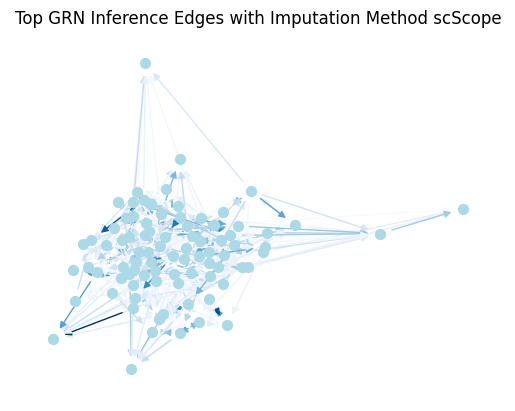

3 DeepImpute
Running DeepImpute
Using all the cores (8)
Input dataset is 1253 cells (rows) and 100 genes (columns)
First 3 rows and columns:
          0         1         2
0  1.000023  1.000023  1.000023
1  1.000023  1.000023  1.000023
2  1.000023  1.000023  1.000023
512 genes selected for imputation
Net 0: 100 predictors, 512 targets
Normalization
Building network
[{'type': 'dense', 'neurons': 256, 'activation': 'relu'}, {'type': 'dropout', 'rate': 0.2}]
Fitting with 1253 cells
Train on 1191 samples, validate on 62 samples
Epoch 1/500


/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/deepimpute/deepimpute/multinet.py:356: UserWarning: Warning: number of target genes lower than output dim. Consider lowering down the sub_outputdim parameter
  warnings.warn('Warning: number of target genes lower than output dim. Consider lowering down the sub_outputdim parameter',
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-05-22 20:42:42.347022: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense/bias/v/Assign' id:929 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/v, training/Adam/dense/bias/v/Initializer/zeros)}}' was changed by setting attribute 

1191/1191 [==============================] - 0s 146us/sample - loss: 8.9463 - val_loss: 8.7629
Epoch 2/500
1191/1191 [==============================] - 0s 16us/sample - loss: 8.4215 - val_loss: 8.1839
Epoch 3/500
1191/1191 [==============================] - 0s 14us/sample - loss: 7.7897 - val_loss: 7.4611
Epoch 4/500
1191/1191 [==============================] - 0s 14us/sample - loss: 7.0130 - val_loss: 6.5899
Epoch 5/500
1191/1191 [==============================] - 0s 14us/sample - loss: 6.1755 - val_loss: 5.6848
Epoch 6/500
1191/1191 [==============================] - 0s 16us/sample - loss: 5.4063 - val_loss: 4.9384
Epoch 7/500
1191/1191 [==============================] - 0s 16us/sample - loss: 4.8704 - val_loss: 4.4967
Epoch 8/500
1191/1191 [==============================] - 0s 16us/sample - loss: 4.5819 - val_loss: 4.2681
Epoch 9/500
1191/1191 [==============================] - 0s 16us/sample - loss: 4.4304 - val_loss: 4.1444
Epoch 10/500
1191/1191 [==============================] -

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-05-22 20:42:42.476008: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:761 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1191/1191 [==============================] - 0s 16us/sample - loss: 4.0929 - val_loss: 3.8444
Epoch 13/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.9804 - val_loss: 3.7464
Epoch 14/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.8729 - val_loss: 3.6355
Epoch 15/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.7638 - val_loss: 3.5265
Epoch 16/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.6521 - val_loss: 3.4128
Epoch 17/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.5317 - val_loss: 3.3049
Epoch 18/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.4283 - val_loss: 3.1887
Epoch 19/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.3123 - val_loss: 3.0817
Epoch 20/500
1191/1191 [==============================] - 0s 16us/sample - loss: 3.1997 - val_loss: 2.9771
Epoch 21/500
1191/1191 [==========================

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-22 20:42:45.994316: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softplus' id:738 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softplus}} = Softplus[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-22 20:42:46.033768: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1_1/bias/Assign' id:1068 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/bias/Assign}} = AssignVariableOp[_has_manua

Elapsed time: 4.20 seconds


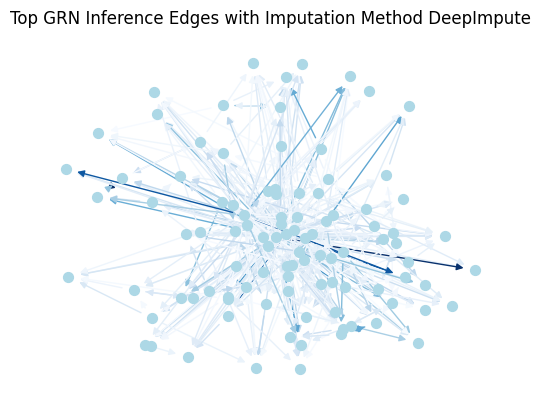

4 MAGIC
Running MAGIC
./zero_imputation_experiments/sampled.npy ./zero_imputation_experiments/sampled.npy
Calculating MAGIC...
  Running MAGIC on 1253 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 2.54 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 2.55 seconds.
Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads


/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 58 and 59, 58 and 445, 58 and 678, 59 and 445, 59 and 678, 445 and 678. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


Elapsed time: 11.46 seconds


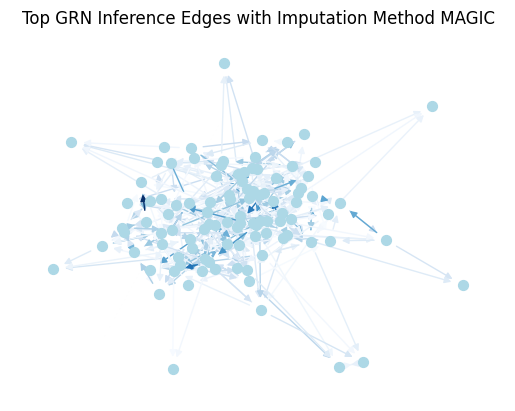

IoU for SAUCIE: 0.0560
IoU for scScope: 0.0741
IoU for DeepImpute: 0.5408
IoU for MAGIC: 0.0638


In [87]:
ret_edges = run_GRN_and_graph(df, n_genes=100)

baseline_edges = ret_edges['None']
iou_scores = {}

for method, edges in ret_edges.items():
    if method != 'None':
        intersection = baseline_edges.intersection(edges)
        union = baseline_edges.union(edges)
        iou_score = len(intersection) / len(union)
        iou_scores[method] = iou_score
        print(f"IoU for {method}: {iou_score:.4f}")